#Titanic Data XAI Experiment 

In a first experiment with DL-Learner we want to familiarize with the tool and see the degree to which this XAI approach is feasible. For doing so we have selected a data set targeted at machine learning students, the Titanic Dataset. The data is already described in chapter 3 of the statement, and further documentation could be consulted for more insights of it.

## Data description

Pursuing to train DL-Learner over this dataset it had first to be mapped into OWL format, specifically into an .nt (N-Triples) file. The schema of the vocabulary is shown in the figure

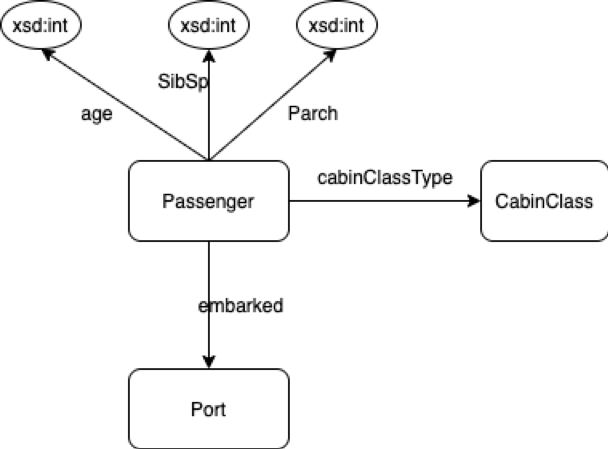

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this following block of code we import all the necessary packages, we create the graph, parse the .nt file and set the namespace.

In [4]:
!pip install rdflib 

import rdflib
from rdflib import Graph, Namespace, Literal, XSD, URIRef
from rdflib.namespace import RDF, RDFS
from rdflib.plugins.sparql import prepareQuery
import random
g = Graph()
g.namespace_manager.bind('titanic', Namespace("http://www.titanicTrial#"), override=False)
g.parse("https://raw.githubusercontent.com/pablodonisebri/TFM/master/Experiment1_Titanic/Titanic.nt?token=ALO7573TNXAV3W7C7SVSE3LA5RXTO",format="nt")
titanic = Namespace("http://www.titanicTrial#")

## Queries to check the expressions provided by DL-Learner

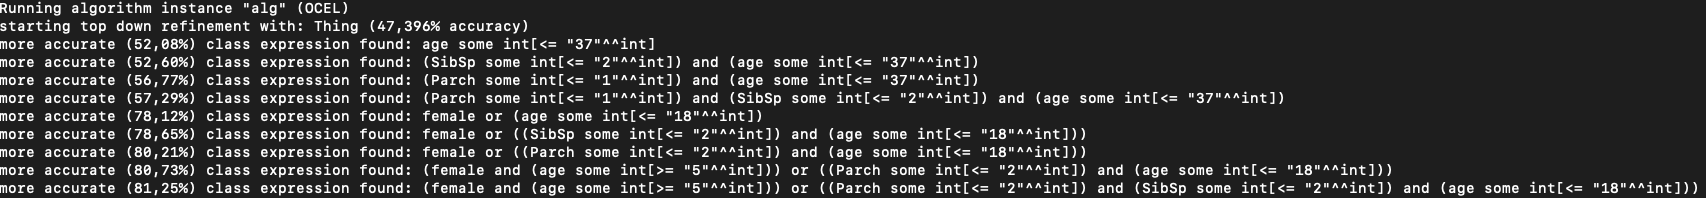

In the figure above we got all the expressions provided by DL-Learner after having been trained over the data. We will only use the top five in terms of accuracy. They are the following:



 Expression 1: 78.12\% accuracy 

1.   Expression 1: 
$$ female \cup ((SibSp \ \leq 2) \cap (age \leq 18) ) $$

2.   Expression 2: 
$$ female \cup ((SibSp \ \leq 2) \cap (age \leq 18) ) $$

3. Expression 3: 
$$ female \cup ((Parch \ \leq 2) \cap (age \leq 18) ) $$

4. Expression 4: 
$$ (female \cap (age \geq 5)) \cup ((Parch \ \leq 2) \cap (age \leq 18) ) $$

5. Expression 5: 
$$ (female \cap (age \geq 5)) \cup ((Parch \ \leq 2)\cap (SibSp \ \leq 2) \cap (age \leq 18)  ) $$
    
Those expressions are implemented in below in the format of an ASK type query.

The function check recieves the instance to be checked and the number of the expression to be checked, returns the evaluation of the expression in the form of true or false.

In [5]:
check1=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{
  {?passenger a titanic:female.}
UNION{
  ?passenger titanic:age ?age.
  FILTER(?age <=18)
}

}
''',initNs = {"titanic": titanic})




check2=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{
  {?passenger a titanic:female.}
UNION{
  ?passenger titanic:age ?age.
  ?passenger titanic:SibSp ?sib.
  FILTER(?age <=18 && ?sib <=2)
}

}
''',initNs = {"titanic": titanic})



check3=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{
  {?passenger a titanic:female.}
UNION{
  ?passenger titanic:age ?age.
  ?passenger titanic:Parch ?parch.
  FILTER(?age <=18 && ?parch <=2)
}

}
''',initNs = {"titanic": titanic})




check4=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{
  {?passenger a titanic:female.
  ?passenger titanic:age ?age.
  FILTER(?age >=5)}
UNION{
  ?passenger titanic:age ?age.
  ?passenger titanic:Parch ?parch.
  FILTER(?age <=18 && ?parch <=2)
}

}
''',initNs = {"titanic": titanic})



check5=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{
  {?passenger a titanic:female.
  ?passenger titanic:age ?age.
  FILTER(?age >=5)}
UNION{
  ?passenger titanic:age ?age.
  ?passenger titanic:Parch ?parch.
  ?passenger titanic:SibSp ?sib
  FILTER(?age <=18 && ?parch <=2 && ?sib <=2)
}

}
''',initNs = {"titanic": titanic})


def check(i,instance):
  checks=[check1,check2,check3,check4,check5]
  return list(g.query(checks[i],initBindings={'?passenger': URIRef(instance)}))[0]

Example of use of check method, where we are evaluating the expression 1 for the passenger with id 1.




```
<http://www.titanicTrial#1> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.titanicTrial#male>.
<http://www.titanicTrial#1> <http://www.titanicTrial#age> "22"^^<http://www.w3.org/2001/XMLSchema#int>.
<http://www.titanicTrial#1> <http://www.titanicTrial#cabinClass> <http://www.titanicTrial#B96_B98>.
<http://www.titanicTrial#1> <http://www.titanicTrial#Parch> "1"^^<http://www.w3.org/2001/XMLSchema#int>.
<http://www.titanicTrial#1> <http://www.titanicTrial#SibSp> "0"^^<http://www.w3.org/2001/XMLSchema#int>.
<http://www.titanicTrial#1> <http://www.titanicTrial#embarked> <http://www.titanicTrial#S>.
```
The passenger is a male of 22 years old, so the evaluation of expression 1 should return false.


In [7]:
check(1,"http://www.titanicTrial#1")

False

In [8]:
for x in g.query(check1,initBindings={'?passenger': URIRef("http://www.titanicTrial#1")}):
  print(x)

False


In [ ]:
q1 = prepareQuery('''

SELECT ?s ?age
WHERE { ?s titanic:Parch ?age }
ORDER BY DESC(?age) LIMIT 1

  ''',
  initNs = { "titanic": titanic}
)


for x in g.query(q1):
  print(x)

(rdflib.term.URIRef('http://www.titanicTrial#864'), rdflib.term.Literal('8', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#int')))


## Similarity Measure

We now want to implement a way of measuring the similarity among instances, we are doing so by implementing the distance explained in the statement.


  $d(p_1,p_2) =$
  \begin{cases}
                                   d_E(p_1,p_2) & \text{if $sex. p_1 = sex. p_2$} \\
                                   1 +d_E(p_1,p_2)  & \text{if $sex. p_1 \neq sex.p_2$}
  \end{cases}

The implementation of such similarity measure is in the function distance that receives the two instances to compare and returns the measure of the similarity normalized. 

We normalize the distance, for the age by dividing by 100 (the age goes from 0 to 100), the Parch by 8 and SibSp by 6. 


In [ ]:
#Query to get all the desired attributes of the instances, ?passenger is passed as argument
distanceQuery = prepareQuery('''
  SELECT DISTINCT
    ?age ?parch ?sib ?type
  WHERE{
  ?passenger a ?type.
  ?passenger titanic:age ?age.
  ?passenger titanic:Parch ?parch.
  ?passenger titanic:SibSp ?sib.}
  ''',
  initNs = { "titanic": titanic}
)


def distance(p1:str, p2:str)->float:
  #Obtain the desired attributes of instance number 1 
  p1_l = list(g.query(distanceQuery,initBindings={'?passenger':rdflib.term.URIRef(p1)}))
  #Obtain the desired attributes of instance number 2
  p2_l=list(g.query(distanceQuery,initBindings={'?passenger':rdflib.term.URIRef(p2)}))
  #Obtain the euclidean distance of between the two isntances (normalized)
  result=( abs(int(p1_l[0][0])-int(p2_l[0][0]))/100 ,abs(int(p1_l[0][1])-int(p2_l[0][1]))/8 ,abs(int(p1_l[0][2])-int(p2_l[0][2]))/6)
  #If they are not from the same sex we add 1 to the distance
  type_dif= 0
  if p1_l[0][3]!=p2_l[0][3]: type_dif=1
  return sum(result)+type_dif


# Perturbations of the instances

Having implemented a way to compute the similarity among instances, we need now to implement a way of perturbing the instances. 

We perturb the instances by doing:

$$ \text{Artificial Instance Age}  = \text{Real instance age} + \delta_{age}, \ \   \delta_{age} \in [-10, 10]$$

$$ \text{Artificial Instance SibSp}  = \text{Real instance SibSp} + \delta_{SibSp}, \ \ \delta_{SibSp} \in [-2, 2]$$

$$ \text{Artificial Instance Parch}  = \text{Real instance Parch} + \delta_{Parch}, \ \ \delta_{Parch} \in [-3, 3] $$


This is implemented in the function perturbations that recieves the instance to be perturbed and the number of artificial instances in the surrondings wanted.

In [ ]:
#Query to get all the attributes of the real instance to be perturbed.
#?passenger is passed as an argument
attributesQuery = prepareQuery('''
  SELECT DISTINCT
    ?age ?parch ?sib
  WHERE{
  ?passenger titanic:age ?age.
  ?passenger titanic:Parch ?parch.
  ?passenger titanic:SibSp ?sib.}
  ''',
  initNs = { "titanic": titanic}
)


def perturbations(instance:str,n=100):
  #The attributes of the instance, is a list [[age, parch, sib ]]
  attributes=list(g.query(attributesQuery,initBindings={'?passenger':rdflib.term.URIRef(instance)}))
  #We perturb the real instance the number of times given by n to create 
  # n artificial instances
  for i in range(0,n):
    #We generate the deltas randomly in the intervals set for each one.
    delta_age=random.randint(-10,10)
    delta_sib=random.randint(-2,2)
    delta_parch=random.randint(-3,3)
    #We delete any rest of previous perturbations that could remain in the graph
    g.update('''
      DELETE{?instancep ?p1 ?o1.}
      WHERE {?instancep ?p1 ?o1.}
      ''',
      initNs = {"titanic": titanic},initBindings={'?instancep':URIRef(instance+"_per_"+str(i))})

    #We insert the artificial instance generated from the real instance by getting the 
    #original age, parch or sibling and adding the deltas, the rest of the attributes remain unchanged
    g.update('''
     
      INSERT {

        ?instancep titanic:isPerturbationOf ?instance.
        ?instancep a ?type.
        ?instancep titanic:embarked ?port.
        ?instancep titanic:cabinClass ?cabin.
        ?instancep titanic:age ?age_p.
        ?instancep titanic:SibSp ?sib_p.
        ?instancep titanic:Parch ?parch_p.
       
        }
      WHERE { 
         
         
         ?instance a ?type.
         ?instance titanic:embarked ?port.
         ?instance titanic:cabinClass ?cabin.
         
         
          }
      ''',
      initNs = {"titanic": titanic},initBindings={'?instancep':URIRef(instance+"_per_"+str(i)),'?instance':URIRef(instance),
                                                 "?age_p":Literal(int(attributes[0][0])+delta_age, datatype=URIRef('http://www.w3.org/2001/XMLSchema#int')),
                                                 "?parch_p":Literal(int(attributes[0][1])+delta_parch, datatype=URIRef('http://www.w3.org/2001/XMLSchema#int')),
                                                 "?sib_p":Literal(int(attributes[0][2])+delta_sib, datatype=URIRef('http://www.w3.org/2001/XMLSchema#int')),
                                                   }) 

An example (shown in the statement) of the use of the perturbations of instance with id 9.

In [ ]:
perturbations("http://www.titanicTrial#9",n=1)

Attributes of the original instance.

In [ ]:
q = prepareQuery('''
  SELECT DISTINCT
    ?p ?o
  WHERE{
  titanic:9 ?p ?o.
  }
  ''',
  initNs = { "titanic": titanic}
)

for x in g.query(q):
  print(x)

(rdflib.term.URIRef('http://www.titanicTrial#SibSp'), rdflib.term.Literal('2', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#int')))
(rdflib.term.URIRef('http://www.titanicTrial#embarked'), rdflib.term.URIRef('http://www.titanicTrial#S'))
(rdflib.term.URIRef('http://www.titanicTrial#cabinClass'), rdflib.term.URIRef('http://www.titanicTrial#B96_B98'))
(rdflib.term.URIRef('http://www.titanicTrial#age'), rdflib.term.Literal('27', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#int')))
(rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.titanicTrial#female'))
(rdflib.term.URIRef('http://www.titanicTrial#Parch'), rdflib.term.Literal('0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#int')))


Attributes of the perturbed instance.

In [ ]:
q = prepareQuery('''
  SELECT DISTINCT
    ?p ?o
  WHERE{
  titanic:9_per_1 ?p ?o.
  }
  ''',
  initNs = { "titanic": titanic}
)

for x in g.query(q):
  print(x)

(rdflib.term.URIRef('http://www.titanicTrial#age'), rdflib.term.Literal('32', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#int')))
(rdflib.term.URIRef('http://www.titanicTrial#SibSp'), rdflib.term.Literal('3', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#int')))
(rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.titanicTrial#female'))
(rdflib.term.URIRef('http://www.titanicTrial#Parch'), rdflib.term.Literal('1', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#int')))
(rdflib.term.URIRef('http://www.titanicTrial#cabinClass'), rdflib.term.URIRef('http://www.titanicTrial#B96_B98'))
(rdflib.term.URIRef('http://www.titanicTrial#isPerturbationOf'), rdflib.term.URIRef('http://www.titanicTrial#9'))
(rdflib.term.URIRef('http://www.titanicTrial#embarked'), rdflib.term.URIRef('http://www.titanicTrial#S'))


Distance among the two instances.

In [ ]:
distance('http://www.titanicTrial#9','http://www.titanicTrial#9_per_1')

0.3416666666666667

## Stability Quantification and Stability Comparison

In the following block of code is the implementation of the quantification of stability in the way described in the statement:

$$\text{Stability of expression}= \dfrac{\displaystyle\sum_{m}^{i}  \sum_{j}^{n}  \lambda(p_i,p_{i.j}) \cdot d(p_i,p_{i.j}) }{n \cdot m}$$


Where $d(p_i, p_j)$ is already explained and implemented above.

We check the stability for all the five expressions simultaneously in order to compare them.

In [ ]:
def stabilityMetricComparison(instances,n=100):
 
  stabilities=[0,0,0,0,0]
  #For each instance we will create the perturbations and check the stability
  # of each expression on the perturbations
  for instance in instances:
    #We create the perturbations of the instance
    perturbations(instance,n=100)
    #For each expression check the stability on the perturbations
    for j in range(0,5):
      #We get the classification for the real instance
      original_clasi_j=check(j,instance)
      #A list of tuples that has the distance and the classification of the  artificial instance
      perturbationsj=[(check(j,instance+"_per_"+str(i)),distance(instance,instance+"_per_"+str(i))) for i in range(0,n)]

      stabilities[j]=stabilities[j]+sum([pertur[1] for pertur in perturbationsj if pertur[0] == original_clasi_j])

  return stabilities

In [ ]:
stabilityMetricComparison(["http://www.titanicTrial#98" ])

[31.351666666666663,
 35.195,
 34.19333333333333,
 34.19333333333333,
 37.27833333333333]

Test set in which we are testing and comparing the stability of the five different expressions. In it there is a total of 192 compounds.

In [ ]:
test=["http://www.titanicTrial#3" ,
"http://www.titanicTrial#4" ,
"http://www.titanicTrial#9" ,
"http://www.titanicTrial#10" ,
"http://www.titanicTrial#11" ,
"http://www.titanicTrial#12" ,
"http://www.titanicTrial#16" ,
"http://www.titanicTrial#18" ,
"http://www.titanicTrial#20" ,
"http://www.titanicTrial#22" ,
"http://www.titanicTrial#23" ,
"http://www.titanicTrial#24" ,
"http://www.titanicTrial#26" ,
"http://www.titanicTrial#29" ,
"http://www.titanicTrial#32" ,
"http://www.titanicTrial#33" ,
"http://www.titanicTrial#37" ,
"http://www.titanicTrial#40" ,
"http://www.titanicTrial#44" ,
"http://www.titanicTrial#45" ,
"http://www.titanicTrial#48" ,
"http://www.titanicTrial#53" ,
"http://www.titanicTrial#54" ,
"http://www.titanicTrial#56" ,
"http://www.titanicTrial#57" ,
"http://www.titanicTrial#59" ,
"http://www.titanicTrial#62" ,
"http://www.titanicTrial#66" ,
"http://www.titanicTrial#67" ,
"http://www.titanicTrial#69" ,
"http://www.titanicTrial#75" ,
"http://www.titanicTrial#79" ,
"http://www.titanicTrial#80" ,
"http://www.titanicTrial#82" ,
"http://www.titanicTrial#83" ,
"http://www.titanicTrial#85" ,
"http://www.titanicTrial#86" ,
"http://www.titanicTrial#89" ,
"http://www.titanicTrial#98" ,
"http://www.titanicTrial#99" ,
"http://www.titanicTrial#107" ,
"http://www.titanicTrial#108" ,
"http://www.titanicTrial#110" ,
"http://www.titanicTrial#124" ,
"http://www.titanicTrial#126" ,
"http://www.titanicTrial#128" ,
"http://www.titanicTrial#129" ,
"http://www.titanicTrial#134" ,
"http://www.titanicTrial#137" ,
"http://www.titanicTrial#142" ,
"http://www.titanicTrial#143" ,
"http://www.titanicTrial#147" ,
"http://www.titanicTrial#152" ,
"http://www.titanicTrial#157" ,
"http://www.titanicTrial#162" ,
"http://www.titanicTrial#166" ,
"http://www.titanicTrial#167" ,
"http://www.titanicTrial#173" ,
"http://www.titanicTrial#184" ,
"http://www.titanicTrial#185" ,
"http://www.titanicTrial#187" ,
"http://www.titanicTrial#188" ,
"http://www.titanicTrial#191" ,
"http://www.titanicTrial#193" ,
"http://www.titanicTrial#194" ,
"http://www.titanicTrial#195" ,
"http://www.titanicTrial#196" ,
"http://www.titanicTrial#199" ,
"http://www.titanicTrial#205" ,
"http://www.titanicTrial#208" ,
"http://www.titanicTrial#209" ,
"http://www.titanicTrial#210" ,
"http://www.titanicTrial#212" ,
"http://www.titanicTrial#216" ,
"http://www.titanicTrial#217" ,
"http://www.titanicTrial#219" ,
"http://www.titanicTrial#221" ,
"http://www.titanicTrial#225" ,
"http://www.titanicTrial#227" ,
"http://www.titanicTrial#231" ,
"http://www.titanicTrial#234" ,
"http://www.titanicTrial#238" ,
"http://www.titanicTrial#242" ,
"http://www.titanicTrial#248" ,
"http://www.titanicTrial#249" ,
"http://www.titanicTrial#256" ,
"http://www.titanicTrial#257" ,
"http://www.titanicTrial#258" ,
"http://www.titanicTrial#259" ,
"http://www.titanicTrial#260" ,
"http://www.titanicTrial#262" ,
"http://www.titanicTrial#1" ,
"http://www.titanicTrial#5" ,
"http://www.titanicTrial#6" ,
"http://www.titanicTrial#7" ,
"http://www.titanicTrial#8" ,
"http://www.titanicTrial#13" ,
"http://www.titanicTrial#14" ,
"http://www.titanicTrial#15" ,
"http://www.titanicTrial#17" ,
"http://www.titanicTrial#19" ,
"http://www.titanicTrial#21" ,
"http://www.titanicTrial#25" ,
"http://www.titanicTrial#27" ,
"http://www.titanicTrial#28" ,
"http://www.titanicTrial#30" ,
"http://www.titanicTrial#31" ,
"http://www.titanicTrial#34" ,
"http://www.titanicTrial#35" ,
"http://www.titanicTrial#36" ,
"http://www.titanicTrial#38" ,
"http://www.titanicTrial#39" ,
"http://www.titanicTrial#41" ,
"http://www.titanicTrial#42" ,
"http://www.titanicTrial#43" ,
"http://www.titanicTrial#46" ,
"http://www.titanicTrial#47" ,
"http://www.titanicTrial#49" ,
"http://www.titanicTrial#50" ,
"http://www.titanicTrial#51" ,
"http://www.titanicTrial#52" ,
"http://www.titanicTrial#55" ,
"http://www.titanicTrial#58" ,
"http://www.titanicTrial#60" ,
"http://www.titanicTrial#61" ,
"http://www.titanicTrial#63" ,
"http://www.titanicTrial#64" ,
"http://www.titanicTrial#65" ,
"http://www.titanicTrial#68" ,
"http://www.titanicTrial#70" ,
"http://www.titanicTrial#71" ,
"http://www.titanicTrial#72" ,
"http://www.titanicTrial#73" ,
"http://www.titanicTrial#74" ,
"http://www.titanicTrial#76" ,
"http://www.titanicTrial#77" ,
"http://www.titanicTrial#78" ,
"http://www.titanicTrial#81" ,
"http://www.titanicTrial#84" ,
"http://www.titanicTrial#87" ,
"http://www.titanicTrial#88" ,
"http://www.titanicTrial#90" ,
"http://www.titanicTrial#91" ,
"http://www.titanicTrial#92" ,
"http://www.titanicTrial#93" ,
"http://www.titanicTrial#94" ,
"http://www.titanicTrial#95" ,
"http://www.titanicTrial#96" ,
"http://www.titanicTrial#97" ,
"http://www.titanicTrial#100" ,
"http://www.titanicTrial#101" ,
"http://www.titanicTrial#102" ,
"http://www.titanicTrial#103" ,
"http://www.titanicTrial#104" ,
"http://www.titanicTrial#105" ,
"http://www.titanicTrial#106" ,
"http://www.titanicTrial#109" ,
"http://www.titanicTrial#111" ,
"http://www.titanicTrial#112" ,
"http://www.titanicTrial#113" ,
"http://www.titanicTrial#114" ,
"http://www.titanicTrial#115" ,
"http://www.titanicTrial#116" ,
"http://www.titanicTrial#117" ,
"http://www.titanicTrial#118" ,
"http://www.titanicTrial#119" ,
"http://www.titanicTrial#120" ,
"http://www.titanicTrial#121" ,
"http://www.titanicTrial#122" ,
"http://www.titanicTrial#123" ,
"http://www.titanicTrial#125" ,
"http://www.titanicTrial#127" ,
"http://www.titanicTrial#130" ,
"http://www.titanicTrial#131" ,
"http://www.titanicTrial#132" ,
"http://www.titanicTrial#133" ,
"http://www.titanicTrial#135" ,
"http://www.titanicTrial#136" ,
"http://www.titanicTrial#138" ,
"http://www.titanicTrial#139" ,
"http://www.titanicTrial#140" ,
"http://www.titanicTrial#141" ,
"http://www.titanicTrial#144" ,
"http://www.titanicTrial#145" ,
"http://www.titanicTrial#146" ,
"http://www.titanicTrial#148" ,
"http://www.titanicTrial#149" ,
"http://www.titanicTrial#150" ,
"http://www.titanicTrial#151" ,
"http://www.titanicTrial#153" ,
"http://www.titanicTrial#154" ,
"http://www.titanicTrial#155"]

In the following  block it is shown the comparison of the stability of the expressions on the test set. It confirms our intuition that simpler expressions tend to be more stable.

In [ ]:
stabilityMetricComparison(test)

[8350.711666666672,
 8230.450000000004,
 8264.906666666668,
 8164.730000000001,
 8149.181666666669]